
# Convolutional Neural Network CNN
1. Using Word2Vec implementing CNN model
2. Dispaly Confusion Matrix, precision, recall and F1-score
3. Display few prediction using predict module. 
4. Get 10-fold Average of the CNN model.

In [124]:
from __future__ import division, print_function

# dataframe
import pandas as pd

# numpy array
import numpy as np

# figures visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
import seaborn as sns

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

# word2vec
import gensim 
from gensim import models
from gensim.models import Word2Vec 
from gensim.models import KeyedVectors

# CNN model and keras preprocessing
import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding, Conv2D, GlobalMaxPooling2D
from keras.models import Sequential
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# nltk data preprocessing
import nltk
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize 
from nltk.stem import WordNetLemmatizer

# stopword - remove buzz word
from nltk.corpus import stopwords

# splitting data
from sklearn.model_selection import train_test_split

# punctuation - data imbalance
import collections
import re
import string

# File path
import os
import os.path
from os import path

# Translator
import googletrans
from googletrans import Translator

In [125]:
# original hindi file
filename  = 'Eng-Hin-data/hindi-anot-shuffled'
orig_df = pd.read_csv(filename + '.csv',  
               delimiter=',')
orig_df.columns = ['Text', 'Label']

In [126]:
orig_df.head

<bound method NDFrame.head of                                                    Text  Label
0     'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #Is...      0
1        '@SanjayGadhiaINC @IndiaToday18 अज़ाबे इलाही 👍      1
2     'आखिर अब #सुशांत_सिंह_राजपूत जी को न्याय मिल ज...      0
3     'अमीन के 500 से अधिक छात्रों ने सर्वे भवन के ग...      0
4     '@deoriapolice @Uppolice @myogiadityanath @spg...      0
...                                                 ...    ...
8788                  '@atullondhe राहुल गांधी जिंदाबाद      0
8789  'पैगंबर हज़रत मुहम्मद सल्लल्लाहु अलैहि वसल्लम ...      1
8790  'कर्नाटक बेंगलुरू में अल्लाह मोहम्मद गांडू के ...      2
8791  'अच्छी खबर है ऐसे एक एक कर सभी जेहादी भारतीय फ...      2
8792  '@Ruzena__Malik जनता चाइना से दीवाली की लड़ी ख...      0

[8793 rows x 2 columns]>

In [127]:
orig_df.Text[6]

"'आज के दिन ही मेरा क्रिकेट प्रेम भी समाप्त हो गया"

In [128]:
# For non English data
if not path.exists(filename + '-translated.csv'):
    print("Translated file does not exist")
    p_data = pd.read_csv("Eng-Hin-data/hindi-anot-shuffled.csv")
    #data =  data.drop('Strength',1)
    translator = Translator()
    col_one_list = p_data['Text'].tolist()
    len(col_one_list)
    result = []
    for i  in range(len(col_one_list)):
        try:
            trans = translator.translate(col_one_list[i], dest='en')
            result.append(trans.text)
        except:
                result.append(col_one_list[i])
    p_data['Text'] = result
    p_data.to_csv(filename + '-translated.csv', index=False)
    df = pd.read_csv(filename + '-translated.csv',  
                   delimiter=',')
    df.columns = ['Text', 'Label']
    df.head(15)
    df["Text"] = df["Text"].astype(str)
    df["Label"] = df["Label"].astype(str)
    data = df
else:
    print("Translated file exist")
    df = pd.read_csv(filename + '-translated.csv',  
                   delimiter=',')
    df.columns = ['Text', 'Label']
    df.head(15)
    df["Text"] = df["Text"].astype(str)
    df["Label"] = df["Label"].astype(str)
    data = df

Translated file exist


In [129]:
df.Text[6]

"'Today also my cricket love has ended"

### Class count

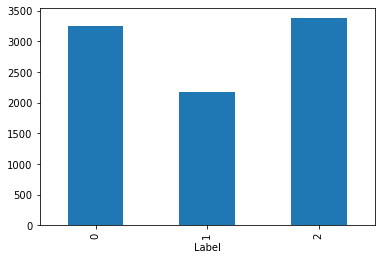

In [130]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [131]:
# For entire dataset sentences for each labels 
df.Label.value_counts()

2    3374
0    3246
1    2173
Name: Label, dtype: int64

### Balancing Data

In [132]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [133]:
new_text, new_label = balanceClasses(df['Text'], df['Label'])

In [134]:
data = pd.DataFrame(new_text)
data.columns = ['Text']
data['Label'] = new_label
data = pd.concat([df, data])

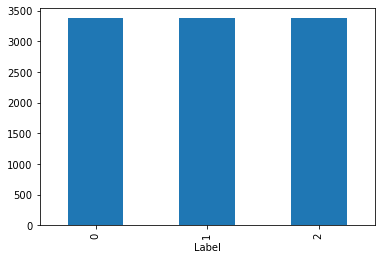

In [135]:
fig1 = plt.figure(figsize=(6,4))
data.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [136]:
data.Label.value_counts()

2    3374
1    3373
0    3373
Name: Label, dtype: int64

### Data Preprocessing

In [137]:
# People usually join sentences using more than one colon 

def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceFourColon(x))

In [138]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"@", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['Text'] = data['Text'].apply(lambda x: textPattern(x))

In [139]:
data.shape

(10120, 2)

In [140]:
# Word Tokenization
tokens = [word_tokenize(sen) for sen in data.Text]

In [141]:
# Lower Case
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [142]:
# Remove Link

def removeLink(token):
    word = []
    for w in token:
        if not w.startswith('http'):
            word.append(w)
    return word 
    
removedLink_tokens = [removeLink(token) for token in lower_tokens]

In [143]:
# Word Lemmatization
def lemmatization(token):
    return [lemmatizer.lemmatize(w) for w in token] 

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [lemmatization(token) for token in removedLink_tokens]

In [144]:
filtered_words = [sen for sen in lemmatized_tokens]
data['Text_Final'] = [' '.join(sen) for sen in filtered_words]
data['tokens'] = filtered_words

In [145]:
zero  = []
one = []
two = []
for l in data.Label:
    
    if l == '0':
        zero.append(1)
        one.append(0)
        two.append(0)
    elif l == '1':
        zero.append(0)
        one.append(1)
        two.append(0)
    elif l == '2':
        zero.append(0)
        one.append(0)
        two.append(1)
        
data['0']= zero
data['1']= one
data['2']= two

data = data[['Text_Final', 'tokens', 'Label', '0', '1', '2']]

In [147]:
category_id = []
for l in data.Label:
    
    if l == '0':
        category_id.append('0')
    elif l == '1':
        category_id.append('1')
    elif l == '2':
        category_id.append('2')
        
data['Category_id'] = category_id

data = data[['Text_Final', 'tokens', 'Label', '0', '1', '2', 'Category_id' ]]
data.head(25)

,Text_Final,tokens,Label,0,1,2,Category_id
0,happy diwali greeting in gaza friend 😊💐 # isra...,"[happy, diwali, greeting, in, gaza, friend, 😊💐...",0,1,0,0,0
1,sanjaygadhiainc indiatoday18 azabe elahi 👍,"[sanjaygadhiainc, indiatoday18, azabe, elahi, 👍]",1,0,1,0,1
2,after all now # sushant_singh_rajput ji will g...,"[after, all, now, #, sushant_singh_rajput, ji,...",0,1,0,0,0
3,more than 500 student of amin performed half -...,"[more, than, 500, student, of, amin, performed...",0,1,0,0,0
4,deoriapolice uppolice myogiadityanath spgrpall...,"[deoriapolice, uppolice, myogiadityanath, spgr...",0,1,0,0,0
5,khanumarfa jihadi thinking when # rahat_indour...,"[khanumarfa, jihadi, thinking, when, #, rahat_...",2,0,0,1,2
6,today also my cricket love ha ended,"[today, also, my, cricket, love, ha, ended]",0,1,0,0,0
7,jihadi thought he had some work of a poet why ...,"[jihadi, thought, he, had, some, work, of, a, ...",2,0,0,1,2
8,sanatan44005733 azadsamajparty0 manikar3002388...,"[sanatan44005733, azadsamajparty0, manikar3002...",2,0,0,1,2
9,sambitswaraj a scared jihadi said to gaurav bh...,"[sambitswaraj, a, scared, jihadi, said, to, ga...",2,0,0,1,2


In [148]:
data = data[data.tokens != '']

In [149]:
from io import StringIO
category_id_df = data[['Label', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_label_dict = dict(category_id_df.values)
label_to_category_dict = dict(category_id_df[['Category_id', 'Label']].values)

#### Split Data into test and train
We will use 90 % data for training and 10 % for testing. We use random state so every time we get the same training and testing data.

In [150]:
data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)


In [151]:
# # total training words
totalTrainingWords = [word for tokens in data_train["tokens"] for word in tokens]

# # Storing Length of the training sentence
lengthTrainingSentences = [len(tokens) for tokens in data_train["tokens"]]

# # training Vocabulary size
trainingVocabSize = sorted(list(set(totalTrainingWords)))

## Total number of lines
linesCount = len(data_train["tokens"])

### Load Google News Glove model

In [152]:
# Run only once
# Convert Glove file to word2vec format 
from gensim.scripts.glove2word2vec import glove2word2vec

# glove_input_file = 'glove.6B.300d.txt'  # I unzipped in glove.6B subdirectory 
# word2vec_output_file = 'glove.6B.300d.word2vec'
# glove2word2vec(glove_input_file, word2vec_output_file)

In [153]:
# Use the converted Glove file
filename = 'glove.6B.300d.word2vec'
word2vec = KeyedVectors.load_word2vec_format(filename, binary=False)

In [154]:
MAX_SEQUENCE_LENGTH = 150
EMBEDDING_DIM = 300


### Tokenize and Pad sequences

In [155]:
tokenizer = Tokenizer(num_words=len(trainingVocabSize), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 15030 unique tokens.


In [156]:
cnnTrainData = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [157]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(15031, 300)


In [158]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
cnnTestData = pad_sequences(test_sequences, maxlen= MAX_SEQUENCE_LENGTH)

### Define CNN

The model is from the paper 'Convolutional Neural Networks for Sentence Classification' we have updated the network according to our requirement [1]

In [159]:
label_names = ['0', '1', '2']

In [160]:
def ConvolutionalNeuralNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    # Embedding layer
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    
    #Kernal (window) size
    filter_sizes = [2,3,4,5]

    # Convolution Layer and max-pooling
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=512, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)
        
    l_merge = concatenate(convs, axis=1)
    
    # softmax layer for multiclass identification 
    x = Dropout(0.1)(l_merge)  
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss= 'categorical_crossentropy',
                 optimizer = keras.optimizers.RMSprop(learning_rate=1e-3),
#                    optimizer='adam',
                  metrics=['accuracy'])
    return model

In [161]:
# Splitting train data into X_train and y_train
y_train = data_train[label_names].values
x_train = cnnTrainData
y_tr = y_train

In [162]:
# Splitting train data into X_test and y_test
y_test = data_test[label_names].values
x_test = cnnTestData
y_tst = y_test

In [163]:
model = ConvolutionalNeuralNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))

In [164]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 150, 300)     4509300     input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_44 (Conv1D)              (None, 149, 512)     307712      embedding_11[0][0]               
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 148, 512)     461312      embedding_11[0][0]               
___________________________________________________________________________________________

### Train CNN

In [165]:
num_epochs = 10
batch_size = 512

In [166]:
history = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Epoch 1/10
17/17 [==============================] - 54s 3s/step - loss: 4.6683 - accuracy: 0.3601 - val_loss: 1.1750 - val_accuracy: 0.3458
Epoch 2/10
17/17 [==============================] - 55s 3s/step - loss: 1.1187 - accuracy: 0.4306 - val_loss: 1.3863 - val_accuracy: 0.3359
Epoch 3/10
17/17 [==============================] - 55s 3s/step - loss: 0.9928 - accuracy: 0.5059 - val_loss: 0.8924 - val_accuracy: 0.5862
Epoch 4/10
17/17 [==============================] - 53s 3s/step - loss: 0.7367 - accuracy: 0.6740 - val_loss: 0.7375 - val_accuracy: 0.7058
Epoch 5/10
17/17 [==============================] - 50s 3s/step - loss: 0.6241 - accuracy: 0.7343 - val_loss: 0.5422 - val_accuracy: 0.7629
Epoch 6/10
17/17 [==============================] - 53s 3s/step - loss: 0.5704 - accuracy: 0.7469 - val_loss: 0.5770 - val_accuracy: 0.7069
Epoch 7/10
17/17 [==============================] - 54s 3s/step - loss: 0.4994 - accuracy: 0.7876 - val_loss: 0.4420 - val_accuracy: 0.8255
Epoch 8/10
17/17 [==

In [167]:
# evaluate on test data
results = model.evaluate(x_test, y_tst)

32/32 [==============================] - 3s 105ms/step - loss: 0.3630 - accuracy: 0.8557


In [168]:
# predict model
predictions = model.predict(cnnTestData, batch_size=1024, verbose=1)

1/1 [==============================] - 0s 8ms/step


### Testing few sentences using our model

In [169]:

labels = ['0', '1', '2']

def makeprediction(texts):
    tk = Tokenizer()
    tk.fit_on_texts(texts)
    index_list = tk.texts_to_sequences(texts)
    x_train = pad_sequences(index_list, maxlen=150)
    pred = model.predict(x_train)
    result = labels[np.argmax(pred)]
    return result

In [170]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [171]:
sum(data_test.Label==prediction_labels)/len(prediction_labels)

0.8557312252964426

In [172]:
data_test.Label.value_counts()

0    369
2    328
1    315
Name: Label, dtype: int64

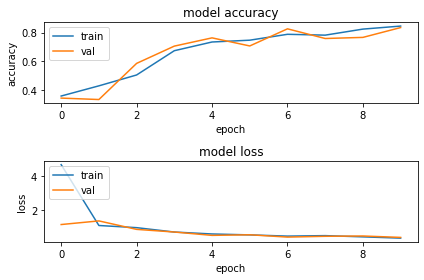

In [174]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [175]:
results = confusion_matrix(data_test.Label, prediction_labels)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(data_test.Label, prediction_labels))
print ('Report : ')
print (classification_report(data_test.Label, prediction_labels))

Confusion Matrix :
[[304  65   0]
 [  1 314   0]
 [  2  78 248]]
Accuracy Score : 0.8557312252964426
Report : 
              precision    recall  f1-score   support

           0       0.99      0.82      0.90       369
           1       0.69      1.00      0.81       315
           2       1.00      0.76      0.86       328

    accuracy                           0.86      1012
   macro avg       0.89      0.86      0.86      1012
weighted avg       0.90      0.86      0.86      1012



                        Convolution Neural Network


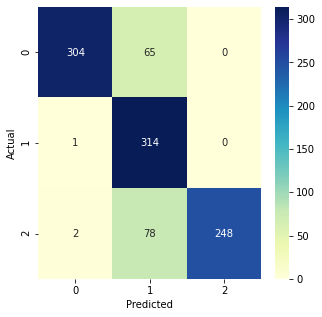

In [176]:
from sklearn.metrics import confusion_matrix
print("                        Convolution Neural Network")
conf_mat = confusion_matrix(data_test.Label, prediction_labels)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap ='YlGnBu',
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Testing CNN using KFold cross validation

In [177]:
from sklearn.model_selection import StratifiedKFold
from scipy.stats import zscore
from sklearn import metrics
import tensorflow as tf
import random

f_score=[]
fold = 10
label_names = ['0', '1', '2']
num_epochs = 5
batch_size = 32
#oos_y = []
#oos_pred = []
results = []
#for train, test in kf.split(data["tokens"], data['Label']):

for i in range(fold):
    print("Fold: ", i+1)
    random_num = np.random.randint(1,7000, 1)[0]
    data_train, data_test = train_test_split(data, test_size=0.10, shuffle = True, random_state = random_num)

    # # total training words
    totalTrainingWords = [word for tokens in data_train["tokens"] for word in tokens]

    # # Storing Length of the training sentence
    lengthTrainingSentences = [len(tokens) for tokens in data_train["tokens"]]

    # # training Vocabulary size
    trainingVocabSize = sorted(list(set(totalTrainingWords)))

    ## Total number of lines
    linesCount = len(data_train["tokens"])
    
    tokenizer = Tokenizer(num_words=len(trainingVocabSize), lower=True, char_level=False)
    tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
    training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

    train_word_index = tokenizer.word_index
    cnnTrainData = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
    
    for word,index in train_word_index.items():
        train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
        
    test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
    cnnTestData = pad_sequences(test_sequences, maxlen= MAX_SEQUENCE_LENGTH)
    
    # Splitting train data into X_train and y_train
    y_train = data_train[label_names].values
    x_train = cnnTrainData
    y_tr = y_train
    
    # Splitting train data into X_test and y_test
    y_test = data_test[label_names].values
    x_test = cnnTestData
    y_tst = y_test
    
    # create model
    model = ConvolutionalNeuralNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))
    
    #Train Model
    history = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)
      
    # model evaluate
    
    print("Results for current fold:")
    results.append(model.evaluate(x_test, y_tst, batch_size=128))

model.save('model_CNN.h5')    

Fold:  1
Epoch 1/5
257/257 [==============================] - 77s 299ms/step - loss: 0.8929 - accuracy: 0.6940 - val_loss: 0.3252 - val_accuracy: 0.8847
Epoch 2/5
257/257 [==============================] - 76s 296ms/step - loss: 0.3413 - accuracy: 0.8657 - val_loss: 0.2875 - val_accuracy: 0.8705
Epoch 3/5
257/257 [==============================] - 70s 273ms/step - loss: 0.3133 - accuracy: 0.8809 - val_loss: 0.2793 - val_accuracy: 0.8661
Epoch 4/5
257/257 [==============================] - 76s 295ms/step - loss: 0.2934 - accuracy: 0.8890 - val_loss: 0.2691 - val_accuracy: 0.8858
Epoch 5/5
257/257 [==============================] - 75s 293ms/step - loss: 0.2627 - accuracy: 0.9012 - val_loss: 0.2945 - val_accuracy: 0.8935
Results for current fold:
8/8 [==============================] - 2s 252ms/step - loss: 0.3038 - accuracy: 0.8972
Fold:  2
Epoch 1/5
257/257 [==============================] - 75s 293ms/step - loss: 0.9167 - accuracy: 0.6801 - val_loss: 0.3484 - val_accuracy: 0.8683
Epoch

In [178]:
import statistics 

score = []
for i in results:
    score.append(i[1])
x = statistics.mean(score)
    
print("Kfold Mean: ", x)

Kfold Mean:  0.8737154185771943


In [179]:
# Prediction 
# translator
translator = Translator()

In [180]:
# 0
texts = ["Sachin: Once there was a fight between Yusuf and Bhajji. Sehwag: Paji, was he Muhammad Yusuf or Yusuf Youhana at that time. This man will not let him live even after retirement."]
print(makeprediction(texts))

1


In [181]:
# 2
texts = ["@_ROB_29 If this was a Muslim girl in Afghanistan you'd call her a terrorist"]
print(makeprediction(texts))

2


In [182]:
# 2
hin_text =  "'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
texts = [trans.text]
print('Predicted Label: ',makeprediction(texts))

Hindi:  'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂
Translated: 'Happy Diwali greetings in Gaza Friends 😊💐 #IsraeliBombing 😂😂
Predicted Label:  2


In [183]:
# 0
hin_text =  " समाज वादी  पार्टी  जिंदाबाद "
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
texts = [trans.text]
print('Predicted Label: ',makeprediction(texts))

Hindi:   समाज वादी  पार्टी  जिंदाबाद 
Translated: Samajwadi Party Zindabad
Predicted Label:  1


In [184]:
# 1
hin_text =  "इसलाम सुंदर है"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
texts = [trans.text]
print('Predicted Label: ',makeprediction(texts))

Hindi:  इसलाम सुंदर है
Translated: Islam is beautiful
Predicted Label:  1


### Reference
[1] "Convolutional Neural Networks for Sentence Classification" by Yoon Kim
